In [1]:
!pip install --upgrade pip -q
!pip install tensorboard tensorflow -q
!pip install datasets -q
!pip install pillow -q
!pip install langchain langchain_community -q
!pip install sentence-transformers -q 

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from tensorboard.plugins import projector
import tensorflow as tf
from datasets import load_dataset
import pandas as pd
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%reload_ext tensorboard

# Init folders

In [4]:
#refresh logs 
!rm -rf ./logs

# Create Embeddings (Vector + Labels)

In [5]:
# EMBEDDING WITH LANGCAHIN + HUGGING FACE
model = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Print the embeddings
for sentence in sentences:
    embedding = model.embed_query('TEST')
    print("Sentence:", sentence)
    print("Embedding:", embedding[:5])
    print("Size:", len(embedding))
    print("")


Sentence: This framework generates embeddings for each input sentence
Embedding: [0.011573508381843567, 0.025136180222034454, -0.03670182079076767, 0.05932481214404106, -0.007148992270231247]
Size: 384

Sentence: Sentences are passed as a list of string.
Embedding: [0.011573508381843567, 0.025136180222034454, -0.03670182079076767, 0.05932481214404106, -0.007148992270231247]
Size: 384

Sentence: The quick brown fox jumps over the lazy dog.
Embedding: [0.011573508381843567, 0.025136180222034454, -0.03670182079076767, 0.05932481214404106, -0.007148992270231247]
Size: 384



In [6]:
# EMBEDDING WITHOUT LANGCAHIN + HUGGING FACE
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding[:5])
    print("Size:", len(embedding))
    print("")


Sentence: This framework generates embeddings for each input sentence
Embedding: [-0.01371734 -0.04285149 -0.01562863  0.01405368  0.03955384]
Size: 384

Sentence: Sentences are passed as a list of string.
Embedding: [ 0.05645246  0.05500242  0.03137961  0.03394851 -0.03542471]
Size: 384

Sentence: The quick brown fox jumps over the lazy dog.
Embedding: [0.04393353 0.05893445 0.04817836 0.07754811 0.02674437]
Size: 384



# Set saving directories 

In [7]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/test'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [8]:
# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for label in sentences:
    print(label)
    f.write("{}\n".format(label))

This framework generates embeddings for each input sentence
Sentences are passed as a list of string.
The quick brown fox jumps over the lazy dog.


In [9]:
#with open(os.path.join(log_dir, "embeddings.tsv"), "w", encoding="utf-8") as f:
#    for embedding in embeddings:
#        f.write("\t".join(map(str, embedding)) + "\n")

# Transform Embeddings in Tensorflow variables

In [10]:
# Save embeddings in TF variable.
emb = tf.Variable(embeddings, name='embedding')

In [11]:
# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=emb)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

'./logs/test/embedding.ckpt-1'

# Set up Tensorboard config 

In [12]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'test/metadata.tsv'

projector.visualize_embeddings(log_dir, config)

In [14]:
# %tensorboard --logdir={log_dir}  #Don't forget to select PROJECTOR from the TensorBoard dropdown

In [15]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances

No known TensorBoard instances running.


# Text embeddings projections (Movie Reviews)

IMDB Data:

We will be using a dataset of 25,000 IMDB movie reviews, each of which has a sentiment label (positive/negative). Each review is preprocessed and encoded as a sequence of word indices (integers). For simplicity, words are indexed by overall frequency in the dataset, for instance the integer "3" encodes the 3rd most frequent word appearing in all reviews. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for any specific word, but instead is used to encode any unknown word. Later in the tutorial, we will remove the row for "0" in the visualization.



In [16]:
# read data
dataframe = pd.read_csv('./data/movie_plots.csv')
dataframe


,MovieID,Titles,Plots,Genres
0,1,Toy Story (1995),A little boy named Andy loves to be in his roo...,animation
1,2,Jumanji (1995),When two kids find and play a magical board ga...,fantasy
2,3,Grumpier Old Men (1995),Things don't seem to change much in Wabasha Co...,comedy
3,6,Heat (1995),Hunters and their prey--Neil and his professio...,action
4,7,Sabrina (1995),An ugly duckling having undergone a remarkable...,romance
...,...,...,...,...
1838,136016,The Good Dinosaur (2015),In a world where dinosaurs and humans live sid...,animation
1839,139855,Anomalisa (2015),"Michael Stone, an author that specializes in c...",animation
1840,142997,Hotel Transylvania 2 (2015),The Drac pack is back for an all-new monster c...,animation
1841,145935,"Peanuts Movie, The (2015)","Charlie Brown, Lucy, Snoopy, and the whole gan...",animation


In [45]:
#Sentences are encoded by calling model.encode()
embeddings_movies = model.encode(dataframe['Plots'])
print(type(embeddings_movies[0]))
print(embeddings_movies[0].shape)

#Print the embeddings
for sentence, emb in zip(dataframe['Plots'], embeddings_movies):
    print("Sentence:", sentence)
    print("Embedding:", emb[:5])
    print("Size:", len(emb))
    print("")

embeddings_movies[0]

<class 'numpy.ndarray'>
(384,)
Sentence: A little boy named Andy loves to be in his room, playing with his toys, especially his doll named "Woody". But, what do the toys do when Andy is not with them, they come to life. Woody believes that he has life (as a toy) good. However, he must worry about Andy's family moving, and what Woody does not know is about Andy's birthday party. Woody does not realize that Andy's mother gave him an action figure known as Buzz Lightyear, who does not believe that he is a toy, and quickly becomes Andy's new favorite toy. Woody, who is now consumed with jealousy, tries to get rid of Buzz. Then, both Woody and Buzz are now lost. They must find a way to get back to Andy before he moves without them, but they will have to pass through a ruthless toy killer, Sid Phillips.
Embedding: [ 0.01752202  0.02964011  0.08000233 -0.03890042  0.01745843]
Size: 384

Sentence: When two kids find and play a magical board game, they release a man trapped for decades in it an

array([ 1.75220221e-02,  2.96401083e-02,  8.00023302e-02, -3.89004201e-02,
        1.74584258e-02,  2.56449524e-02,  1.74151897e-01,  2.09814776e-02,
       -3.72628979e-02,  4.69148830e-02,  4.67485785e-02, -1.62954889e-02,
       -2.16386318e-02,  2.34786179e-02,  5.51488437e-02,  9.06250179e-02,
        2.48711240e-02, -4.70000878e-02, -5.02829440e-02, -3.38656711e-03,
       -7.68083846e-04, -1.25157386e-02,  8.09976384e-02, -1.44340023e-02,
       -6.54761419e-02,  9.93172526e-02,  2.34252550e-02, -9.94753931e-03,
       -3.69400829e-02, -1.59356948e-02,  5.78985587e-02,  1.63870864e-03,
        3.56625812e-03, -4.20196541e-02, -1.91803481e-02,  5.54514229e-02,
        3.85031179e-02, -1.83721017e-02,  3.19461375e-02, -2.85775661e-02,
       -1.93412006e-02,  1.91202071e-02, -6.31770939e-02, -2.27150992e-02,
       -5.28005771e-02, -2.19634138e-02, -3.26884538e-02, -4.95336615e-02,
        7.66716376e-02, -3.24004591e-02, -6.96210004e-03, -6.70724437e-02,
        7.71883205e-02,  

In [46]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/movies'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for label in dataframe['Genres']:
    f.write("{}\n".format(label))  


# Save embeddings in TF variable.
emb = tf.Variable(embeddings_movies, name='embedding')

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=emb)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

%load_ext tensorboard

# Set up config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()

# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'

projector.visualize_embeddings(log_dir, config)

%reload_ext tensorboard
%tensorboard --logdir={log_dir}  #Don't forget to select PROJECTOR from the TensorBoard dropdown


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 90813), started 0:34:36 ago. (Use '!kill 90813' to kill it.)

In [31]:
!kill 90755

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Image embeddings (Mnist)

https://www.youtube.com/watch?v=7a605K00Dr8

https://deepnote.com/@kamalpatel/Fashion-MNIST-3cdf53de-d1bc-4e92-a722-25ec6e902111

https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorboard.plugins import projector
import tensorflow_datasets as tfds

mnist, info = tfds.load('mnist', split='train', with_info=True)
tfds.as_dataframe(mnist.take(4), info)

2024-01-20 14:53:34.879273: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,4
1,,1
2,,0
3,,7


2024-01-20 14:53:35.102475: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


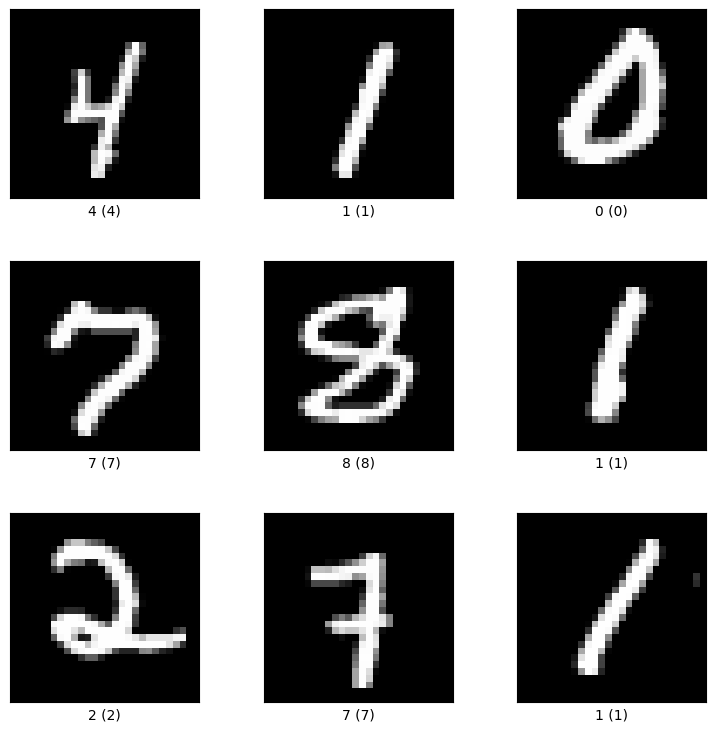

In [20]:
fig = tfds.show_examples(mnist, info)

In [21]:
tfds.as_dataframe(mnist.take(1))

2024-01-20 14:53:35.373831: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


image  label
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      4

In [54]:
df = tfds.as_dataframe(mnist)
print(df.columns)
df = df[:1600]
print(len(df))
len(df['image'].iloc[0].flatten())


Index(['image', 'label'], dtype='object')
1600


784

In [55]:
embedding_df = df['image']
embeddings_mnist = embedding_df.tolist()
embeddings_mnist = [np.float32(e.flatten()/255) for e in embeddings_mnist]
label_df = df['label']
labels = label_df.tolist()
len(embeddings_mnist[0])
np.float32(embeddings_mnist[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [60]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/mnist'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as meta:
    meta.write('Index\tLabel\n')
    for index, label in enumerate(labels):
        meta.write('{}\t{}\n'.format(index, label))


# create the sprite.png image 
rows = 28
cols = 28
label = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9'] # mape the numbers lable to its name
sprite_dim = int(np.sqrt(embedding_df.shape[0])) #dim of  sprite.png is sqrt (number of row in csv)
sprite_image = np.ones((cols * sprite_dim, rows * sprite_dim)) # creat blank(temblate) sprite_image
index = 0
name = []
for i in range(sprite_dim):
    for j in range(sprite_dim):
        
        #name.append(label[int(labels[index])]) # get what is image(get its number that is lable in csv) the map this number to lable name 
        
        sprite_image[
            i * cols: (i + 1) * cols,
            j * rows: (j + 1) * rows
        ] = embedding_df[index].reshape(28, 28) * -1 + 1
        
        index += 1


%load_ext tensorboard
        
embedding_var = tf.Variable(embeddings_mnist, name='embedding') # embedding variable

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig() # use the projector
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprite.png'
embedding.sprite.single_image_dim.extend([28, 28]) # size of single image in the sprite

plt.imsave(os.path.join(log_dir, embedding.sprite.image_path), sprite_image, cmap='gray')


projector.visualize_embeddings(log_dir, config) # configuire projector

# KILL THE TENSORBOARD BEFORE EVERY RUN !!!!!!!!!

%reload_ext tensorboard
%tensorboard --logdir={log_dir}  #Don't forget to select PROJECTOR from the TensorBoard dropdown

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 92209), started 0:00:14 ago. (Use '!kill 92209' to kill it.)

In [58]:
!kill 90760

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [40]:
print(sprite_image.shape)
print(np.sqrt(60000)*28)

(616, 616)
22.0


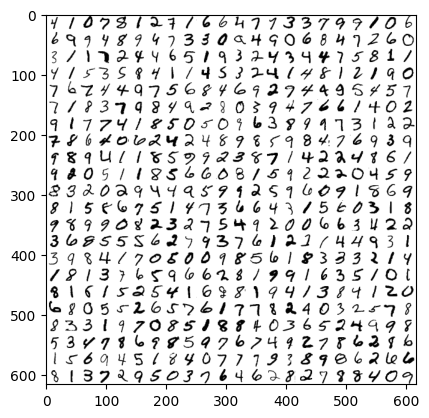

In [26]:
plt.imshow(sprite_image, cmap='gray')
plt.show()

# Image embeddings (Fashion Mnist)

https://www.youtube.com/watch?v=7a605K00Dr8

https://deepnote.com/@kamalpatel/Fashion-MNIST-3cdf53de-d1bc-4e92-a722-25ec6e902111

https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin

In [119]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorboard.plugins import projector
import tensorflow_datasets as tfds

# Dataset copied here ->  /Users/nicolasfradin/tensorflow_datasets/fashion_mnist/
fashion_mnist, info = tfds.load('fashion_mnist', split='train', with_info=True)
tfds.as_dataframe(mnist.take(4), info)

2024-01-21 13:02:17.056626: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


,image,label
0,,2 (Pullover)
1,,1 (Trouser)
2,,8 (Bag)
3,,4 (Coat)


2024-01-20 15:46:27.165594: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


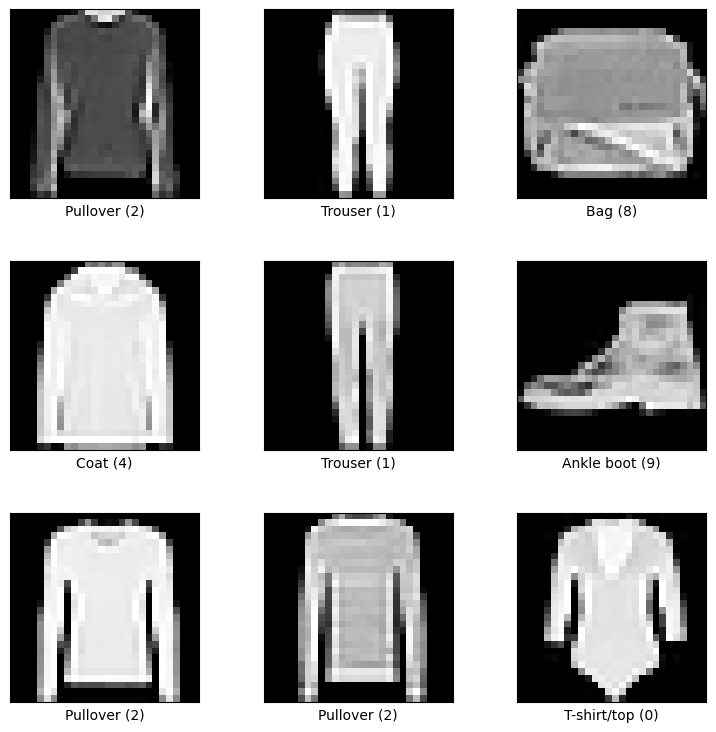

In [63]:
fig = tfds.show_examples(fashion_mnist, info)

In [64]:
tfds.as_dataframe(fashion_mnist.take(1))

2024-01-20 15:46:31.338623: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


image  label
0  [[[0], [0], [0], [0], [0], [0], [0], [0], [0],...      2

In [65]:
df = tfds.as_dataframe(fashion_mnist)
print(df.columns)
df = df[:1600]
print(len(df))
len(df['image'].iloc[0].flatten())


Index(['image', 'label'], dtype='object')
1600


784

In [66]:
embedding_df = df['image']
embeddings_mnist = embedding_df.tolist()
embeddings_mnist = [np.float32(e.flatten()/255) for e in embeddings_mnist]
label_df = df['label']
labels = label_df.tolist()
len(embeddings_mnist[0])
np.float32(embeddings_mnist[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.07058824,
       0.3019608 , 0.8901961 , 0.8901961 , 0.8156863 , 0.8235294 ,
       0.88235295, 0.84705883, 0.33333334, 0.1254902 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.23921569, 0.39215687, 0.38039216, 0.3137255 , 0.22352941,
       0.45882353, 0.8901961 , 0.93333334, 0.4509804 , 0.19215687,
       0.30588236, 0.41568628, 0.42352942, 0.2784314 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.31764707, 0.4117647 , 0.3137255 ,
       0.27058825, 0.28235295, 0.2509804 , 0.17254902, 0.08235294,
       0.05098039, 0.17254902, 0.27058825, 0.29411766, 0.29411

In [70]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/fashion_mnist'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as meta:
    meta.write('Index\tLabel\n')
    for index, label in enumerate(labels):
        meta.write('{}\t{}\n'.format(index, label))


# create the sprite.png image 
rows = 28
cols = 28
label = ['0','1', '2', '3', '4', '5', '6', '7', '8', '9'] # mape the numbers lable to its name
sprite_dim = int(np.sqrt(embedding_df.shape[0])) #dim of  sprite.png is sqrt (number of row in csv)
sprite_image = np.ones((cols * sprite_dim, rows * sprite_dim)) # creat blank(temblate) sprite_image
index = 0
name = []
for i in range(sprite_dim):
    for j in range(sprite_dim):
        
        #name.append(label[int(labels[index])]) # get what is image(get its number that is lable in csv) the map this number to lable name 
        
        sprite_image[
            i * cols: (i + 1) * cols,
            j * rows: (j + 1) * rows
        ] = embedding_df[index].reshape(28, 28) * -1 + 1
        
        index += 1


%load_ext tensorboard
        
embedding_var = tf.Variable(embeddings_mnist, name='embedding') # embedding variable

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig() # use the projector
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprite.png'
embedding.sprite.single_image_dim.extend([28, 28]) # size of single image in the sprite

plt.imsave(os.path.join(log_dir, embedding.sprite.image_path), sprite_image, cmap='gray')


projector.visualize_embeddings(log_dir, config) # configuire projector

# KILL THE TENSORBOARD BEFORE EVERY RUN !!!!!!!!!

%reload_ext tensorboard
%tensorboard --logdir={log_dir}  #Don't forget to select PROJECTOR from the TensorBoard dropdown

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 92293), started 0:00:13 ago. (Use '!kill 92293' to kill it.)

In [ ]:
!kill 90760

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Image Embedding with CLIP 

Pixel brightness is a suitable feature for the MNIST dataset because it comprises simple, grayscale images of handwritten digits, where the contrast between the digit and the background is the most crucial aspect. However, for regular images relying solely on pixel brightness is insufficient. These images have millions of pixels with varying color channels and contain much more complex and diverse visual information. Using pixel brightness as the primary feature in such cases would fail to capture the intricate details, textures, and relationships among objects in the image.

https://medium.com/@kerry.halupka/getting-started-with-openais-clip-a3b8f5277867 

https://github.com/openai/CLIP/blob/main/notebooks/Interacting_with_CLIP.ipynb

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch

img_model = SentenceTransformer('clip-ViT-B-32')
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

In [185]:
# Dataset copied here ->  /Users/nicolasfradin/tensorflow_datasets/fashion_mnist/
cars_images, info = tfds.load('cats_vs_dogs', 
                              split='train', 
                              as_supervised=True,  # Include labels
                              with_info=True,
                              download=True,
                              )

df_images = tfds.as_dataframe(cars_images.take(1000), info)
print(len(df_images))
df_images.head()

1000


,image,label
0,"[[[251, 255, 255], [248, 254, 252], [242, 246,...",1
1,"[[[221, 171, 118], [191, 140, 87], [236, 178, ...",1
2,"[[[174, 180, 152], [182, 188, 160], [189, 195,...",1
3,"[[[91, 65, 6], [93, 67, 8], [92, 66, 7], [92, ...",0
4,"[[[139, 137, 138], [140, 138, 139], [141, 139,...",1


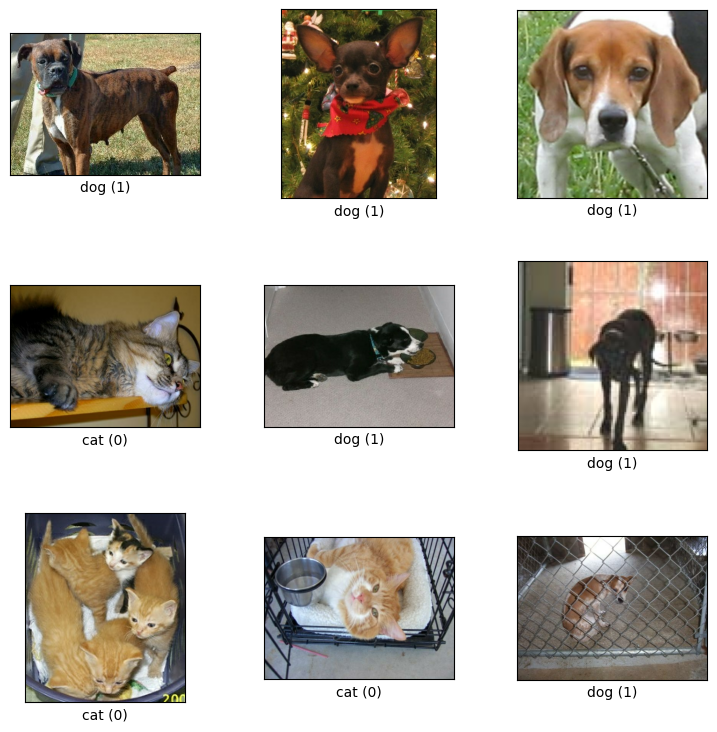

In [186]:
fig = tfds.show_examples(cars_images, info)

In [193]:
images_array = df_images['image'].tolist()
images = []
images_pil_resized = []
labels = df_images['label'].tolist()
for img in images_array:
    images.append(Image.fromarray(np.uint8(img)).convert('RGB'))
    images_pil_resized.append(Image.fromarray(np.uint8(img)).resize((300, 300)))

#df_images['image'] = images
img_embeddings = img_model.encode(images)

print(len(labels))
print(df_images['image'].shape)
print(len(images_array))
print(type(img_embeddings[0]))
print(img_embeddings[0].shape)
print(len(img_embeddings))
print(img_embeddings)
#print(np.array(Image.fromarray(np.uint8(df_images['image'][0])).resize((100, 100))).astype('float32'))


1000
(1000,)
1000
<class 'numpy.ndarray'>
(512,)
1000
[[-3.0279362e-01 -1.2323305e-01 -7.1175891e-01 ...  9.5241129e-01
   2.1129315e-01  1.7810019e-02]
 [ 1.7701432e-01  7.4775919e-02  3.8925970e-01 ...  6.3328457e-01
   3.2027459e-01  1.5353414e-01]
 [-8.4789721e-03 -1.3581428e-01 -5.6393910e-02 ...  2.1935956e-01
   5.2927837e-02  1.1133848e-03]
 ...
 [-1.6522440e-01 -3.9058745e-01 -2.6868293e-01 ...  1.0897824e+00
   1.9490233e-01  2.0488118e-01]
 [-6.3039553e-01 -5.0203609e-01 -3.6048308e-01 ...  8.2484949e-01
   9.5133036e-02  4.3458584e-01]
 [-4.4413546e-01 -2.0220377e-01  2.1836907e-01 ...  1.1153374e+00
   3.4626327e-02  4.4492230e-01]]


In [193]:
# Set up a logs directory, so Tensorboard knows where to look for files
log_dir='./logs/clip'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as meta:
    meta.write('Index\tLabel\n')
    for index, label in enumerate(labels):
        meta.write('{}\t{}\n'.format(index, label))


# create the sprite.png image 
one_square_size = int(np.ceil(np.sqrt(len(img_embeddings))))
master_width = 100 * one_square_size
master_height = 100 * one_square_size
spriteimage = Image.new(
    mode='RGBA',
    size=(master_width, master_height),
    color=(0,0,0,0) # fully transparent
)
for count, image in enumerate(images_pil_resized):
    div, mod = divmod(count, one_square_size)
    h_loc = 100 * div
    w_loc = 100 * mod
    spriteimage.paste(image, (w_loc, h_loc))
spriteimage.convert('RGB').save(f'{log_dir}/sprite.jpg', transparency=0)


%load_ext tensorboard
        
embedding_var = tf.Variable(img_embeddings, name='embedding') # embedding variable

# Add ops to save and restore all the variables.
checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig() # use the projector
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
embedding.sprite.image_path = 'sprite.jpg'
embedding.sprite.single_image_dim.extend([100, 100]) # size of single image in the sprite

projector.visualize_embeddings(log_dir, config) # configuire projector

# KILL THE TENSORBOARD BEFORE EVERY RUN !!!!!!!!!

%reload_ext tensorboard
%tensorboard --logdir={log_dir}  #Don't forget to select PROJECTOR from the TensorBoard dropdown

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 1479), started 0:00:56 ago. (Use '!kill 1479' to kill it.)

In [192]:
!kill 1407

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
